# Huynh Gia Phong Tat

``` py

!pip install takeHomeTest
import takeHomeTest

!pip install time
from time import oneWeek as panic

panic.dump(takeHomeTest)


print("Welcome to your take home final!\n")
```

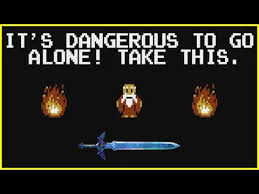




## ------------------------------------------- The Legend of Python --------------------------------------------
**Lore**

In the Kingdom of Pyrovia, all nations once traded in harmony. But since the Shattering of the Global APIs, the knowledge of currency exchange — locked away in XML scrolls — has scattered across the timelines. These scrolls reside in a mysterious repository known only as floatrates.com.

The High Council of Programmers has summoned you (and only you), young code-wielder, to begin your final trial. It is divided into 2 parts.
* Quest 1 (50xp): Retrieving the scrolls of time - Threading and Json save and parsing
* Quest 2 (50xp): Decipher the scrolls - Perform EDA on the data.

------ ------ ------ ------ Extra credit ------ ------ ------ ------ 
* Side Quest 1 (10xp*): Lay down seeds for those that follow - create error logs 
* Side Quest 2 (10xp*): The Quest of reflection  - Use profiling on your code to fully understand it 

*any points over 100% will be rolled over into your final grade. 

I may not have time to run all of your code so make sure you very clearly take notes and communicate successes, issues, and lessons learned. 
Please stay off Chat GPT and stack overflow (and like). You should have most everything you need in the notes. 

--------------------------------------------
# Quest 1 (50 xp): Retrieving the Scrolls of Time 
Retrieve historical exchange rate data from floatrates.com for one of the (Ideally randomly pick) 52 available currencies, starting from the first record on May 4, 2011, until the present day.

- You may store the data as-is in XML, or convert it to JSON, you may use the supplied code below as a starter. 

- Organize each currency into its own directory.

- Ensure your code is modular, maintainable, and robust against timeouts or malformed entries.

## Notes from the Grand Master 
* Threading is your ally. But do not burn out your ally as they have limited resources. You may use the threading or multi-core to parallelize downloads — but mind the server’s load. Around 10 threads is wise. 
    - You should have around 5040 queries.

* XML Scrolls is a new and unfamiliar beast. Therefore takeing on this beast will wield 5 extra experience points. You will not be penalized for choosing to use JSON

*  Use the Save. Nothing is worse than losing experience you have already gained. Save the raw XML (or converted JSON) using timestamped (in my example below) files so you do not need to look it up again. Ie. If you put in a start date and your program has already read that data it should not pull that date again. (it would be a good idea to delete your data and run it top to bottom before final submission)

* Design gracefully. Structure your project with clear modules: downloader.py, parser.py, and so on. 

* Log your quest progress in your quest book to show the Grand Master what you learned this is very important. 


--------------------------------------------

In [1]:
!pip install xmltodict


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
rates = ["EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CLP", "CNY", "COP", "CZK", "DKK", "HUF", "ISK", "INR", "IDR", "ILS", "KZT", "KRW", "KWD", "LYD", "MYR", "MUR", "NPR", "NZD", "NOK", "OMR", "PKR", "PLN", "QAR", "RUB", "SAR", "SGD", "ZAR", "LKR", "SEK", "CHF", "THB", "TTD"]
ratesForBase = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

In [6]:
import requests
import xmltodict
import json
import random

# URL of the XML data
date = "2011-05-04"
base = random.choice(ratesForBase)
url = f"https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date={date}&base_currency_code={base}&format_type=xml"
print(url)
# Fetch the XML data
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

# Parse the XML data to a Python dictionary
data_dict = xmltodict.parse(response.text)

# Convert the dictionary to a JSON string
json_data = json.dumps(data_dict, indent=4)

# Print the JSON data
print(json_data)

# Optionally, write the JSON data to a file
with open(f"{date}_exchange_rates_{base}.json", "w") as json_file:
    json_file.write(json_data)


https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date=2011-05-04&base_currency_code=SGD&format_type=xml
{
    "channel": {
        "title": "XML Historical Foreign Exchange Rates for Singapore Dollar (SGD) (4 May 2011)",
        "link": "http://www.floatrates.com/currency/sgd/",
        "xmlLink": "http://www.floatrates.com/daily/sgd.xml",
        "description": "XML historical foreign exchange rates for Singapore Dollar (SGD) from the Float Rates. Published at 4 May 2011.",
        "language": "en",
        "baseCurrency": "SGD",
        "pubDate": "Wed, 4 May 2011",
        "lastBuildDate": "Wed, 4 May 2011",
        "item": [
            {
                "title": "1 SGD = 0.546641 EUR",
                "link": "http://www.floatrates.com/sgd/eur/",
                "description": "1 Singapore Dollar = 0.546641 Euro",
                "pubDate": null,
                "baseCurrency": "SGD",
                "baseName": "Singapo

## Quest 1
### Currency Directories

In [ ]:
# downloader.py
import requests
import xmltodict
import json
import os
import time
from utils import ensure_dir, get_date_range, chunk_dates

# Taken from template but modified to use some retries, and print ok/fail messages
def get_data(date, base, retries=2):
    url = f"https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date={date}&base_currency_code={base}&format_type=xml"
    folder = ensure_dir(base)
    json_path = os.path.join(folder, f"{date}_exchange_rates_{base}.json")
    xml_path = os.path.join(folder, f"{date}_exchange_rates_{base}.xml")

    if os.path.exists(json_path) and os.path.exists(xml_path):
        print(f"Skipped: {date}")
        return
    # I added a retry loop in case something times out or fails
    for attempt in range(retries + 1):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            # Save raw XML
            with open(xml_path, "w", encoding="utf-8") as xml_file:
                xml_file.write(response.text)
            # Convert XML and save as JSON    
            data_dict = xmltodict.parse(response.text)
            with open(json_path, "w") as json_file:
                json.dump(data_dict, json_file, indent=4)
            print(f"Saved: {date}")
            return
        except Exception as e:
            print(f"Retry {attempt+1}: {date}")

    print(f"Failed: {date}")


In [ ]:
# utils.py
import os
from datetime import datetime, timedelta
from math import ceil

def ensure_dir(base_currency):
    path = os.path.join("data", base_currency)
    os.makedirs(path, exist_ok=True)
    return path

def get_date_range(start_date, end_date):
    days = (end_date - start_date).days
    return [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(days + 1)]

def chunk_dates(dates, n_chunks):
    chunk_size = ceil(len(dates) / n_chunks)
    return [dates[i:i + chunk_size] for i in range(0, len(dates), chunk_size)]


In [ ]:
# main.py
import random
from datetime import datetime
import threading

from utils import get_date_range, chunk_dates
from downloader import get_data

# Taken from template but modified
rates = ["EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CLP", "CNY", "COP", "CZK", "DKK", "HUF", "ISK", "INR", "IDR", "ILS", "KZT", "KRW", "KWD", "LYD", "MYR", "MUR", "NPR", "NZD", "NOK", "OMR", "PKR", "PLN", "QAR", "RUB", "SAR", "SGD", "ZAR", "LKR", "SEK", "CHF", "THB", "TTD"]
rates_for_base = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

start_date = datetime.strptime("2011-01-01", "%Y-%m-%d")
end_date = datetime.today()
max_threads = 15 # Number of threads to use increase a little bit

def threaded_ally(date_chunk, base):
    for date_str in date_chunk:
        get_data(date_str, base)

def main():
    base_currency = random.choice(rates_for_base)
    print(f"Base: {base_currency}")

    all_dates = get_date_range(start_date, end_date)
    chunks = chunk_dates(all_dates, max_threads)
    threads = []

    for chunk in chunks:
        t = threading.Thread(target=threaded_ally, args=(chunk, base_currency))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    print("Done.")

if __name__ == "__main__":
    main()


I used threading to speed up the downloads, splitting the full date range into equal chunks across 10 threads. Each thread handled its own chunk without overlap.
For each date:
I requested data in XML format
I parsed the XML into a dictionary and saved it as JSON
I also saved the raw XML file to earn the "5 bonus XP" (please professor :( )
Files were saved into a folder named after the base currency (e.g., data/MYR/), and each file was named using the date it corresponded to.

Another small issue: when I bumped thread count up to 30, some requests started to fail. The floatrates server likely throttled me or dropped responses due to too many simultaneous requests. I reduced threads back to 10, and that fixed it.

Final Data Snapshot:
Folder created: data/KWD/

Files saved: ~5000 JSON + XML pairs

Size: [670MB]

--------------------------------------------
# Quest 2 (50 XP): Decipher the scrolls – Exploratory Data Analysis

Once the scrolls have been retrieved their knowledge remains unrefined there patterns hidden, trends veiled. Your task now is to become the Seer of Exchange, the one who can read the currencies’ fates through the lens of data.
8
Perform Exploratory Data Analysis (EDA) on the dataset you collected in Quest 1. 
- Aggregate and visualize trends in exchange rate over time for at least 5 major currencies (e.g., USD, EUR, GBP, JPY, CNY).

- Identify periods of volatility — perhaps during economic upheaval

- Generate at least multiple visualizations using seaborn:

- Log your quest progress in your quest book to show the Grand Master what you learned this is very important. some examples of observations are:
    - Anomalies, seasonal patterns, or economic events
    - Currencies with the most/least stability
    - Any interesting correlations between currencies


## Notes from the Grand Master 
- All of your work in this section should be in your jupyter notebook. 

- It might be helpful to use  google to reveal how economic events affected currency. Use Google News or economic calendars to correlate real-world events to exchange rate spikes or dips.


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
base_dirs = ["data/KWD", "data/KZT", "data/QAR", "data/SGD"]
rows = []

for base_dir in base_dirs:
    for filename in os.listdir(base_dir):
        if filename.endswith(".json"):
            try:
                file_path = os.path.join(base_dir, filename)
                with open(file_path, "r") as f:
                    data = json.load(f)

                item = data.get("item") or data.get("channel", {}).get("item")
                date = filename.split("_")[0]
                if isinstance(item, list):
                    for entry in item:
                        rows.append({
                            "base": os.path.basename(base_dir),
                            "date": date,
                            "currency": entry.get("targetCurrency"),
                            "rate": float(entry.get("exchangeRate"))
                        })
                elif isinstance(item, dict):
                    rows.append({
                        "base": os.path.basename(base_dir),
                        "date": date,
                        "currency": item.get("targetCurrency"),
                        "rate": float(item.get("exchangeRate"))
                    })

            except Exception as e:
                print(f"Error in {filename}: {e}")

df = pd.DataFrame(rows)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "rate", "currency"])
print("Data loaded:", df.shape)
print(df.head())

# ----------------------------
# STEP 2: Pivot & Filter
# ----------------------------

df_pivot = df.pivot_table(index="date", columns="currency", values="rate", aggfunc="mean")
df_pivot = df_pivot.sort_index()

df_long = df_pivot.reset_index().melt(id_vars="date", var_name="currency", value_name="rate")

# ----------------------------
# STEP 3: Summary Statistics
# ----------------------------

print("\nSummary Statistics:")
print(df_pivot.describe())

# ----------------------------
# STEP 4: Visualize Major Currency Trends
# ----------------------------

plt.figure(figsize=(12, 6))
selected = ["USD", "EUR", "JPY", "CAD", "AUD"]
sns.lineplot(data=df_long[df_long["currency"].isin(selected)], x="date", y="rate", hue="currency")
plt.title("Exchange Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# STEP 5: Rolling Volatility (30-day Std Dev)
# ----------------------------

plt.figure(figsize=(12, 5))
for currency in selected:
    if currency in df_pivot.columns:
        df_pivot[currency].rolling(30).std().plot(label=currency)
plt.legend()
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Std Dev of Exchange Rate")
plt.tight_layout()
plt.show()

# ----------------------------
# STEP 6: Correlation Heatmap
# ----------------------------

corr_matrix = df_pivot[selected].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Selected Currencies")
plt.tight_layout()
plt.show()


--------------------------------------------


# Side Quest 1 (10 XP): Lay Down Seeds for Those Who Follow – Logging

Even the greatest explorer must leave breadcrumbs for those who walk the path after them. Here you will construct an error log system, a journal that captures both triumphs and catastrophes.

Implement a robust logging system throughout your codebase to monitor:
- Successful currency downloads
- Parsing attempts and failures
- Skipped downloads (due to saved data or time out)
- Connection errors

## Notes from the Grand Master
- You do not need to do log hierarchy 
- Use log levels: INFO for progress, WARNING for skips, ERROR for failures



--------------------------------------------


# Side Quest 2 (10 XP): The quest of Reflection – Code Profiling

The final challenge for any Adventure is introspection — learning the nature of one's own power. In this side quest, you will profile your code, to discover its bottlenecks, inefficiencies, and optimization opportunities.

Use profiling tools to evaluate:
- Which functions are taking the most time
- How threads/processes are behaving
- Whether I/O is a bottleneck

*A random vendor appears* His invintory shows:
- A Profiler function - cProfile or Profile 
- A time module - timeit for micro-benchmarks
- A line profiler - line_profiler